In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [160]:
data = pd.read_csv('Amazon_Unlocked_Mobile.csv')
data = data.head(1000)

In [161]:
print(f"Dataset shape: {data.shape}")
print (f"Feature names: {data.columns.values}")

Dataset shape: (1000, 6)
Feature names: ['Product Name' 'Brand Name' 'Price' 'Rating' 'Reviews' 'Review Votes']


In [162]:
#check for null
data.isnull().sum()

Product Name      0
Brand Name      464
Price             0
Rating            0
Reviews           0
Review Votes     24
dtype: int64

In [163]:
#getting the record where 'verified_reviews ' is null
data[data['Reviews'].isna() == True]

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes


In [164]:
#dropping null record
data.dropna(inplace = True)
#dataset after dropping null valus
print(f"Dataset shape: {data.shape}")

Dataset shape: (535, 6)


In [165]:
# creating a new column 'length' that will contain the length of the string in 'verified_reviews" column
data['length'] = data['Reviews'].apply(len)
data.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,length
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,374
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,214
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,12
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,76
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,223


In [166]:
print(f"'Reviews' column value: {data.iloc[10]['Reviews']}") #Original value
print(f"Length of Review: {len(data.iloc[10]['Reviews'])}") #Length of review using len()",
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'"

'Reviews' column value: My fiance had this phone previously, but caused many problems. So, of course, we decided to browse amazon for a replacement til' our contract is up! & so far so good!
Length of Review: 166
'length' column value : 166


In [167]:
data.dtypes

Product Name     object
Brand Name       object
Price           float64
Rating            int64
Reviews          object
Review Votes    float64
length            int64
dtype: object

ANALYZING THE RATING COLUMN

In [168]:
len(data)

535

In [169]:
#DISTINCT VALUES OF 'RATING' AND ITS COUNT
print(f"Rating value count: \n{data['Rating'].value_counts()}")

Rating value count: 
Rating
5    239
1    136
4     61
2     57
3     42
Name: count, dtype: int64


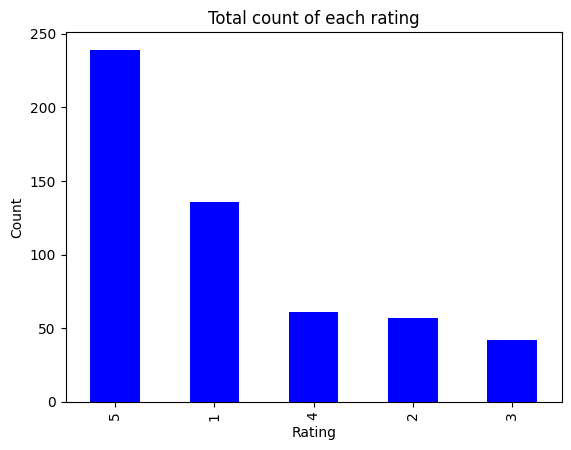

In [170]:
#bar plots to visualize the total count of each rating
import matplotlib.pyplot as plt
data['Rating'].value_counts().plot.bar(color = 'blue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Total count of each rating')
plt.show()

In [171]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records\n",
print(f"Rating value count - percentage distribution: \\n{round(data['Rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: \nRating
5    44.67
1    25.42
4    11.40
2    10.65
3     7.85
Name: count, dtype: float64


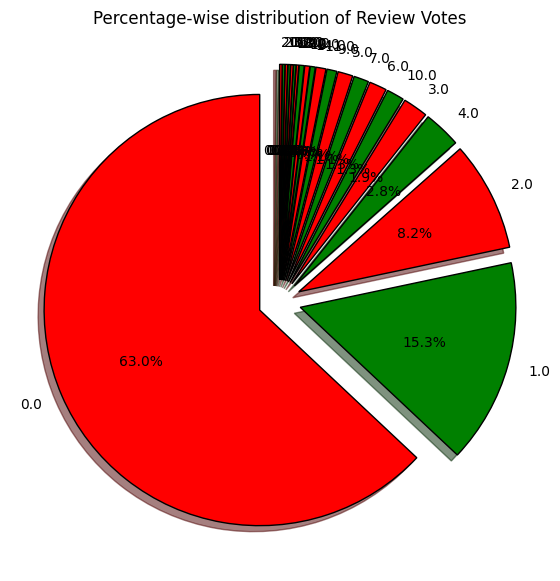

In [172]:
# Create the figure
fig = plt.figure(figsize=(7,7))

# Define colors and wedge properties
colors = ['red', 'green']
wp = {'linewidth': 1, "edgecolor": 'black'}

# Calculate the proportion of each feedback type
tags = data['Review Votes'].value_counts() / data.shape[0]

# Ensure explode matches the length of tags
explode = [0.1] * len(tags)

# Define labels to match the unique values in 'Review Votes' (assuming 0=Negative and 1=Positive)


# Plot the pie chart
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors,
          startangle=90, wedgeprops=wp, explode=explode)

# Set title
plt.title('Percentage-wise distribution of Review Votes')
plt.ylabel('')  # Optional: remove the default y-axis label
plt.show()


ANALYZING FEEDBACK COLUMN

#Distinct values of 'feedback' and its count
print(f"Feedback value count: \n{data['Review Votes'].value_counts()}")

In [173]:
#Extracting the 'verified_reviews' value for one record with feedback = 0
review_1 = data[data['Review Votes'] == 0].iloc[1]['Reviews']
print(review_1)

Very pleased


In [174]:
#Extracting the 'verified_reviews' value for one record with feedback = 1
review_0 = data[data['Review Votes'] == 1].iloc[1]['Reviews']
print(review_0)

I already had a phone with problems... I know it stated it was used, but dang, it did not state that it did not charge. I wish I would have read these comments then I would have not purchased this item.... and its cracked on the side.. damaged goods is what it is.... If trying to charge it another way does not work I am requesting for my money back... AND I WILL GET MY MONEY BACK...SIGNED AN UNHAPPY CUSTOMER....


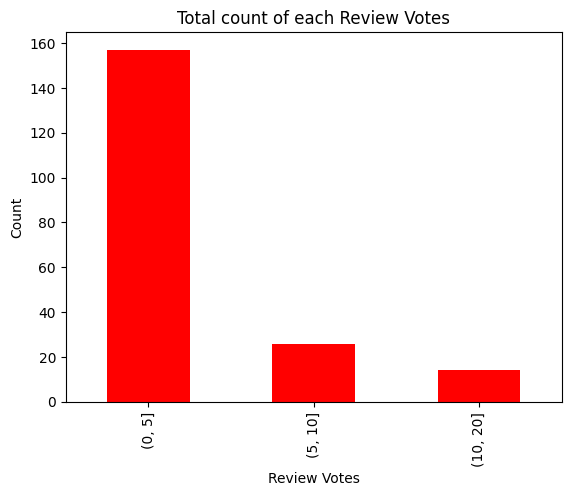

In [175]:
#Bar graph to visualize the total counts of each feedback
data['Review Votes Binned'] = pd.cut(data['Review Votes'], bins=[0, 5, 10, 20])
data['Review Votes Binned'].value_counts().sort_index().plot.bar(color='red')

plt.xlabel('Review Votes')
plt.ylabel('Count')
plt.title('Total count of each Review Votes')
plt.show()

In [176]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records
print(f"Feedback value count - percentage distribution: \n{round(data['Review Votes'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
Review Votes
0.0     62.99
1.0     15.33
2.0      8.22
4.0      2.80
3.0      1.87
10.0     1.31
6.0      1.31
7.0      1.12
5.0      1.12
9.0      0.75
11.0     0.75
14.0     0.37
12.0     0.37
8.0      0.37
19.0     0.19
13.0     0.19
17.0     0.19
16.0     0.19
15.0     0.19
23.0     0.19
20.0     0.19
Name: count, dtype: float64


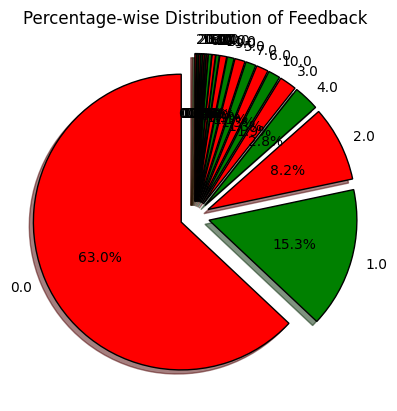

In [177]:
import matplotlib.pyplot as plt

# Assuming 'tags' has been defined as in your code
num_tags = len(tags)

# Adjust explode to match the number of tags
explode = (0.1,) * num_tags  # This will create a tuple of the correct length

# Plotting
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors,
          startangle=90, wedgeprops=wp, explode=explode)

plt.title('Percentage-wise Distribution of Feedback')
plt.ylabel('')  # Hides the y-label
plt.show()


In [178]:
#Feedback = 0
data[data['Review Votes'] == 0]['Rating'].value_counts()

Rating
5    129
1    103
2     40
4     37
3     28
Name: count, dtype: int64

In [179]:
#Feedback = 1
data[data['Review Votes'] == 1]['Rating'].value_counts()

Rating
5    49
1    17
4     8
2     4
3     4
Name: count, dtype: int64

ANALYZING VARIATION

In [180]:
#DISTINCT VALUES OF 'VARIATION' AND ITS COUNT
print(f"Variation value count: \n {data['Brand Name'].value_counts()}")

Variation value count: 
 Brand Name
JUNING                     191
Jethro                     117
Nokia                       73
Samsung                     37
OtterBox                    30
HTM                         24
e passion                   18
Elephone                    11
Plum                        10
Huawei                       9
Cedar Tree Technologies      4
Indigi                       4
Lenovo                       4
Phone Baby                   3
Name: count, dtype: int64


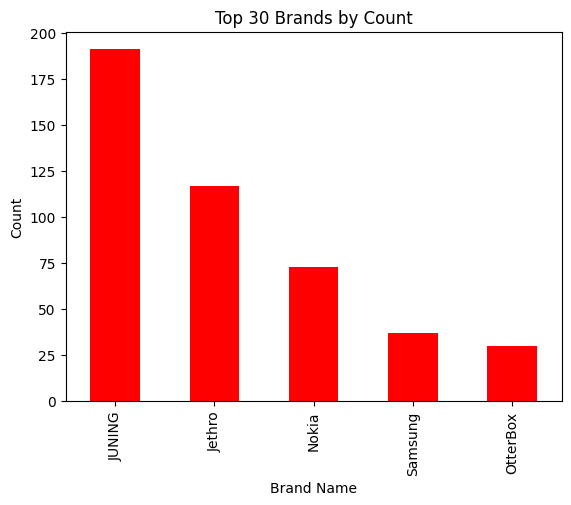

In [181]:
# Plotting the top 50 brands by count in a bar chart
data['Brand Name'].value_counts().head().plot.bar(color='red')
plt.xlabel('Brand Name')
plt.ylabel('Count')
plt.title('Top 30 Brands by Count')
plt.show()


In [182]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records
print(f"Variation value count - percentage distribution: \n{round(data['Brand Name'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
Brand Name
JUNING                     35.70
Jethro                     21.87
Nokia                      13.64
Samsung                     6.92
OtterBox                    5.61
HTM                         4.49
e passion                   3.36
Elephone                    2.06
Plum                        1.87
Huawei                      1.68
Cedar Tree Technologies     0.75
Indigi                      0.75
Lenovo                      0.75
Phone Baby                  0.56
Name: count, dtype: float64


In [183]:
data.groupby('Brand Name')['Rating'].mean()

Brand Name
Cedar Tree Technologies    2.000000
Elephone                   3.545455
HTM                        4.250000
Huawei                     4.333333
Indigi                     2.000000
JUNING                     2.774869
Jethro                     3.589744
Lenovo                     4.750000
Nokia                      4.205479
OtterBox                   4.233333
Phone Baby                 5.000000
Plum                       1.200000
Samsung                    3.702703
e passion                  2.888889
Name: Rating, dtype: float64

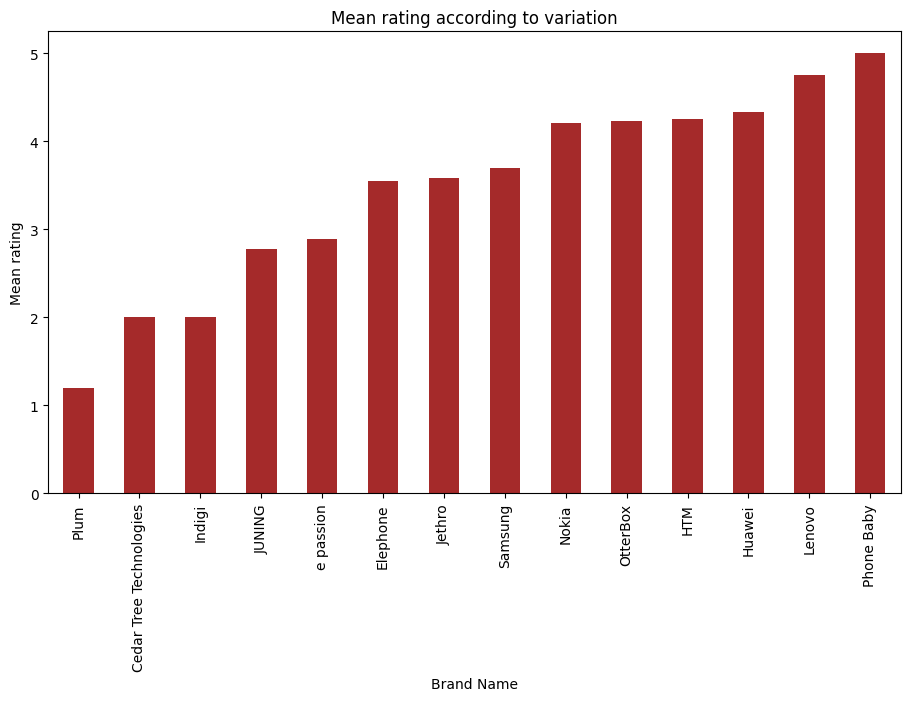

In [184]:
data.groupby('Brand Name')['Rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Brand Name')
plt.ylabel('Mean rating')
plt.show()

In [185]:
data['length'].describe()


count     535.000000
mean      354.368224
std       532.816747
min         3.000000
25%        46.000000
50%       137.000000
75%       374.000000
max      4213.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review ')]

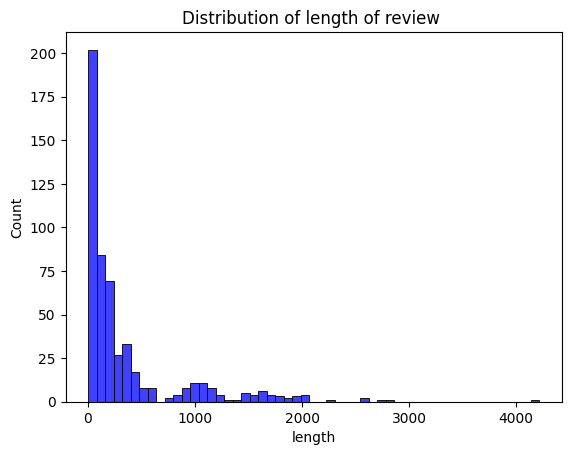

In [186]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

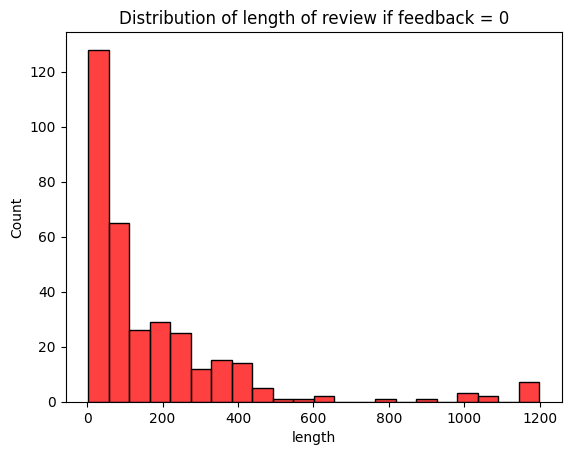

In [187]:
sns.histplot(data[data['Review Votes']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

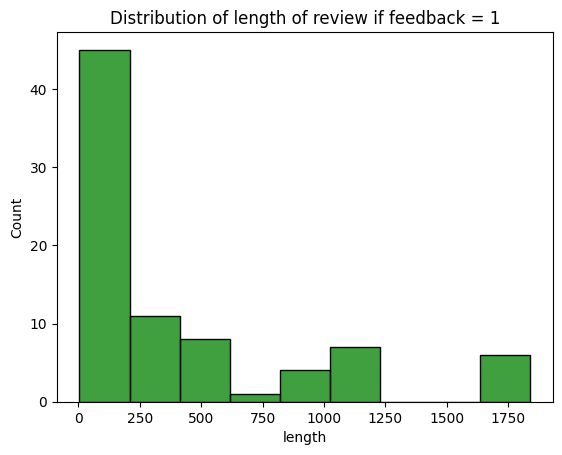

In [188]:
sns.histplot(data[data['Review Votes']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

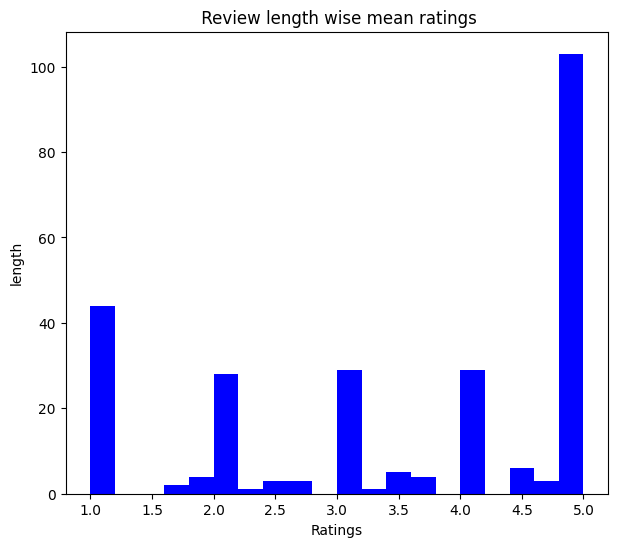

In [189]:
data.groupby('length')['Rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('Ratings')
plt.ylabel('length')
plt.show()

In [190]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.Reviews)

In [191]:
# Combine all reviews
all_reviews = ' '.join(data['Reviews'])

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

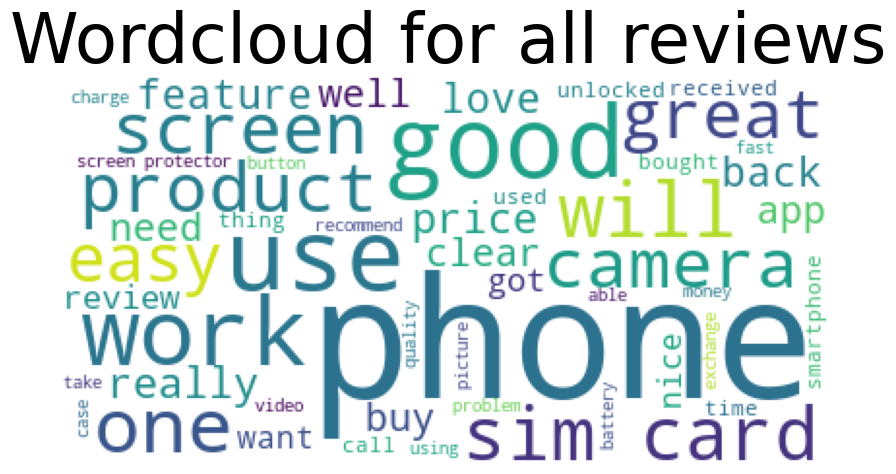

In [192]:
# Initialize wordcloud object
wordcloud = WordCloud(max_words=50, background_color='white')
# Generate and plot wordcloud
wordcloud.generate(all_reviews)
plt.figure(figsize=(10, 10))
plt.title('Wordcloud for all reviews', fontsize=50)
plt.imshow(wordcloud.generate(all_reviews))
plt.axis('off')

Finding Unique words i each category

In [193]:
# Combine all reviews for each feedback category and split them into individual words
neg_reviews = " ".join(data[data['Review Votes'] == 0]['Reviews']).lower().split()
pos_reviews = " ".join(data[data['Review Votes'] == 1]['Reviews']).lower().split()

# Convert lists to sets for faster membership testing
neg_set = set(neg_reviews)
pos_set = set(pos_reviews)

# Find unique words in each category by using set difference
unique_negative = neg_set - pos_set
unique_positive = pos_set - neg_set

# Convert sets back to strings if needed
unique_negative = " ".join(unique_negative)
unique_positive = " ".join(unique_positive)


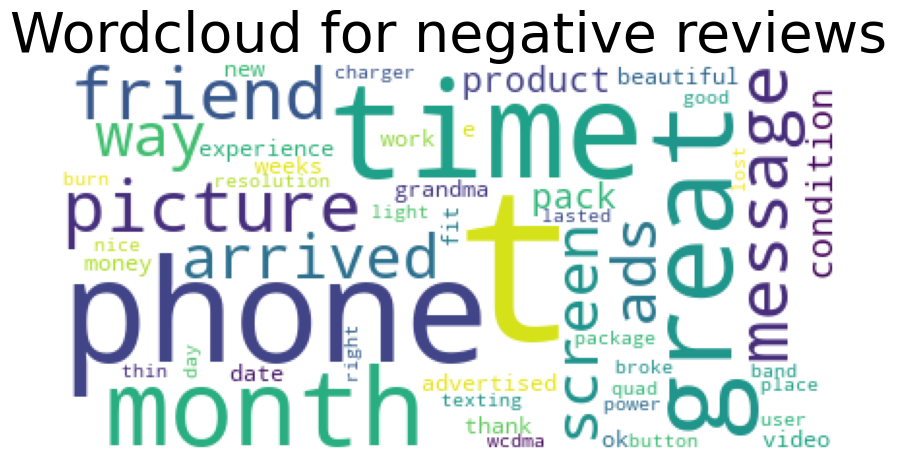

In [194]:
wordcloud = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.title('Wordcloud for negative reviews', fontsize=40)
plt.imshow(wordcloud.generate(unique_negative))
plt.axis('off')
plt.show()

negative words can be found above

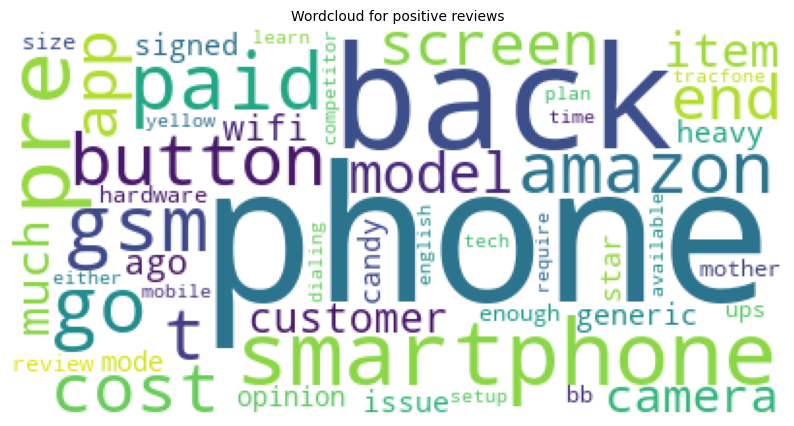

In [195]:
wordcloud = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.imshow(wordcloud.generate(unique_positive))
plt.axis('off')
plt.show()

postove words can be found above

PREPROCESSING AND MODELLING
- To build the corpus from the 'Reviews' we perform the following :
 1. Replace any non alphabet characters with a space
 2. Covert to lower case and split into words 
 3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [196]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['Reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

Using Count Vectorizer to create bag of words

In [197]:
cv = CountVectorizer(max_features = 1000)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).astype('int32').toarray()
y = data['Review Votes'].values

In [198]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

Checking X and Y shape

In [199]:
#checking x and y shape
print(f"X shape {X.shape}")
print(f"Y shape {y.shape}")

X shape (535, 1000)
Y shape (535,)


Splitting data into train and test set

In [200]:
#Splitting data into train and test set with 30% data with testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)
print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (374, 1000)
y train: (374,)
X test: (161, 1000)
y test: (161,)


In [201]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 25
X test max value: 16


In [202]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [203]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

Random Forest

In [204]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    max_features='sqrt',
    max_samples=0.8,
    random_state=42
)

In [205]:
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier(max_depth=10, max_samples=0.8, n_estimators=50,
                       random_state=42)

In [206]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.7941176470588235
Testing Accuracy : 0.7391304347826086


In [207]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [208]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

In [209]:
unique_labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_preds, labels=unique_labels)

<Figure size 1000x800 with 0 Axes>

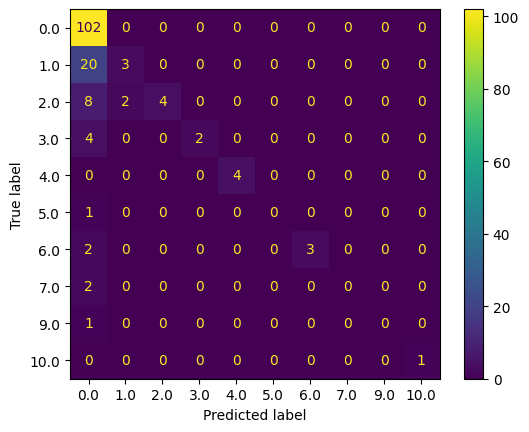

In [210]:
# Select only the first 10 labels for visualization
subset_labels = unique_labels[:10]  # Adjust the range as needed
subset_cm = cm[:10, :10]
# Increase figure size
plt.figure(figsize=(10, 8))

# Display the normalized confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=subset_cm, display_labels=subset_labels)
cm_display.plot()
plt.show()

K fold cross validation

In [211]:

accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

c:\Users\USER\Documents\GitHub\Sentiment-Analysis-on-Products\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Accuracy : 0.6844238975817923
Standard Variance : 0.02898159942488876


Applying grid search

In [212]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix

In [213]:
# Ensure that both X_train_scl and y_train have the same number of samples
X_train_scl_reduced = X_train_scl[:10000]  # Reduce X_train_scl to 10,000 samples
y_train_reduced = y_train[:10000]          # Reduce y_train to 10,000 samples

# Apply PCA to the reduced feature set
pca = PCA(n_components=100)  # You can adjust n_components as necessary
X_train_scl_reduced = pca.fit_transform(X_train_scl_reduced)


In [214]:
# Define your model and parameters
model_rf = RandomForestClassifier()


In [215]:

params = {
    'n_estimators': [100],  # Reduced to one value
    'max_depth': [10],       # Reduced to one value
    'min_samples_split': [2] # Reduced to one value
}

cv_object = StratifiedKFold(n_splits=2)

# Grid search setup with parallel processing
grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv=cv_object, verbose=0, 
                           return_train_score=True, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scl_reduced, y_train_reduced.ravel())

c:\Users\USER\Documents\GitHub\Sentiment-Analysis-on-Products\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10], 'min_samples_split': [2],
                         'n_estimators': [100]},
             return_train_score=True)

In [216]:

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [217]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [218]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 98.66310160427807
Cross validation mean accuracy on test set : 70.85561497326202
Accuracy score for test set : 0.7391304347826086


XgBoost

In [254]:
import numpy as np

# Convert `y_train` to a set of valid classes
valid_classes = set(y_train)

# Create a mask to filter out samples in `y_test` with unseen labels
mask = np.isin(y_test, list(valid_classes))

# Apply the mask to filter `X_test_scl` and `y_test`
X_test_scl = X_test_scl[mask]
y_test = y_test[mask]


In [250]:
# Convert y_train and y_test to integer labels
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [255]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [256]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9742990654205608
Testing Accuracy : 0.7264150943396226


In [260]:
# Assuming X and y are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [261]:
y_preds = model_xgb.predict(X_test)

In [262]:
print(len(y_test), len(y_preds))

107 107


In [265]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[66  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 9  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0]]


In [269]:
# Get the unique classes in y_test
unique_labels = sorted(set(y_test)) 

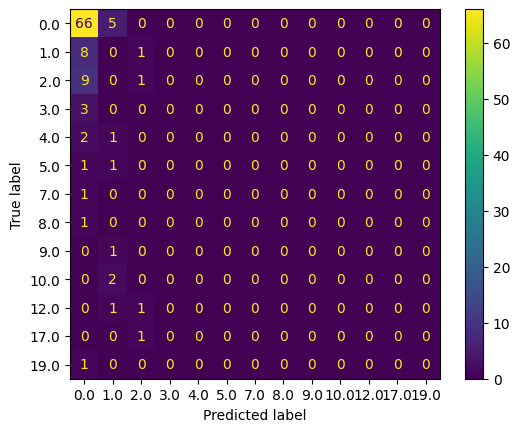

In [271]:
# Ensure display_labels matches the unique values in y_test
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
cm_display.plot()
plt.show()

Decision Tree Classifier

In [239]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [240]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9906542056074766
Testing Accuracy : 0.6728971962616822


In [241]:
y_preds = model_dt.predict(X_test)


In [242]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[49  8  1  0  0  0  0  0  0  0  0  0  6  0  0  7]
 [ 4  3  1  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 7  1  1  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


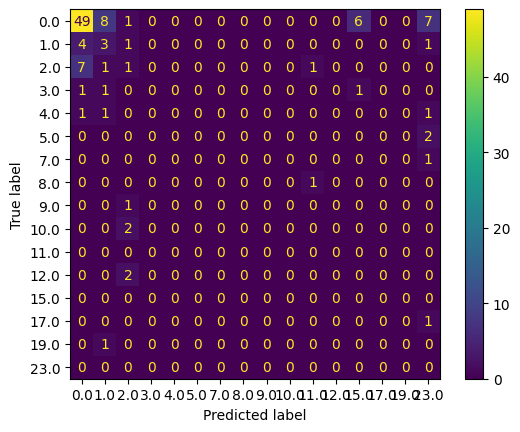

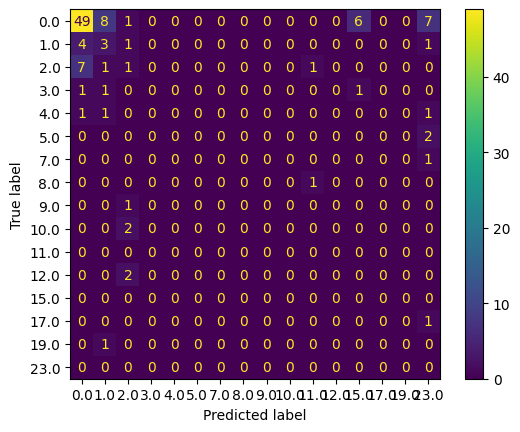

In [248]:
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming y_true and y_pred are defined and contain your true and predicted labels.
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_preds)
cm_display.plot()
plt.show()